In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

43504


In [79]:
save_folder = r'\\mendel\Mendel_SSD1\Pu_Temp\20220102-CTP11-1000_CTP12-DNA_from_1229'

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5'][:]
print(len(save_filenames))

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

17
Use segmentation_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220102-CTP11-1000_CTP12-DNA_from_1229\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220102-CTP11-1000_CTP12-DNA_from_1229\CandSpots


## load codebook

In [3]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_824,NDB_712,NDB_818,NDB_940,NDB_872,NDB_934,NDB_926,NDB_910,chr,chr_order
0,1:3740000-3760000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:6240000-6260000,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1:8740000-8760000,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
3,1:11240000-11260000,4,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1:13740000-13760000,5,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,X:161240000-161260000,1057,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,X,52
984,X:163740000-163760000,1058,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,X,53
985,X:166240000-166260000,1059,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,X,54
986,X:168740000-168760000,1060,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,55


### generate necessary variables for plotting

In [4]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

## find spots

In [136]:
cand_spot_filenames = [os.path.join(cand_spot_folder, _fl) for _fl in os.listdir(cand_spot_folder)
                       if 'CandSpots' in _fl]
print(len(cand_spot_filenames))

1673


In [161]:
# QC cand spots

intensity_th = 1000

combo_ids = np.load(os.path.join(save_folder, 'combo_ids.npy'))
combo_channels = np.load(os.path.join(save_folder, 'combo_channels.npy'))
id_2_channel = {_id:_ch for _id,_ch in zip(combo_ids, combo_channels)}


cand_cand_spot_filenames = [os.path.join(cand_spot_folder, _fl) for _fl in os.listdir(cand_spot_folder)
                       if 'CandSpots' in _fl]
print(len(cand_spot_filenames))
# load 
cand_spot_dicts = []
for _cand_spot_filename in cand_cand_spot_filenames[:]:
    cand_spot_dicts.append(pickle.load(open(_cand_spot_filename, 'rb')))
    
# get stats for spots in each bit
_bit_2_intensities = {_b:[] for _b in combo_ids}
for _spot_dict in cand_spot_dicts:
    for _bit, _spots in _spot_dict.items():
        #print(_bit)
        if len(_spots) > 0:
            _bit_2_intensities[_bit].append(_spots[:,0])

_bit_2_intensities = {_b:np.concatenate(_v) for _b,_v in _bit_2_intensities.items()}
# get median as normalization 
bit_2_median_ints = {_b:np.median(_ints[_ints>intensity_th]) for _b, _ints in _bit_2_intensities.items()}

# normalize
normed_cand_spot_dicts = []

for _dict in cand_spot_dicts:
    _normed_dict = {}
    for _bit, _spots in _dict.items():
        _new_spots = copy.copy(_spots[_spots[:,0] > intensity_th])
        _new_spots[:,0] *= 1 / bit_2_median_ints[_bit]
        _normed_dict[_bit] = _new_spots
    
    # append
    normed_cand_spot_dicts.append(_normed_dict)



1673


<IPython.core.display.Javascript object>


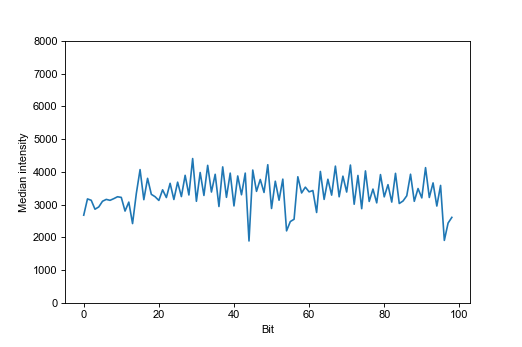

In [162]:
plt.figure()
plt.plot(list(bit_2_median_ints.values()))
plt.xlabel('Bit')
plt.ylabel('Median intensity')
plt.ylim([0,8000])
plt.show()


## prepare decode inputs

In [134]:
from ImageAnalysis3.classes import decode
from ImageAnalysis3.classes.preprocess import Spots3D
reload(decode)

combo_ids = np.load(os.path.join(save_folder, 'combo_ids.npy'))
combo_channels = np.load(os.path.join(save_folder, 'combo_channels.npy'))
id_2_channel = {_id:_ch for _id,_ch in zip(combo_ids, combo_channels)}
pair_search_radius = 300
pixel_sizes = [250,108,108]
debug = True

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
_version = 0
if debug:
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
else:
    _version = 0 # default
# add version info
decoder_folder = os.path.join(decoder_folder, f'v{_version}')

print(decoder_folder)

\\mendel\Mendel_SSD1\Pu_Temp\20220102-CTP11-1000_CTP12-DNA_from_1229\Decoder\v1


In [138]:
%%time
# old version
from ImageAnalysis3.classes import decode
reload(decode)
overwrite = True

# create decoder filenames
decoder_filenames = [os.path.join(decoder_folder,
                                 os.path.basename(_cand_spot_filename).replace('CandSpots', 'Decoder') )
                     for _cand_spot_filename in cand_spot_filenames]
    
decode_args = [(_fl, codebook_df, _decoder_fl, 
                True, True, id_2_channel,
                pixel_sizes, 2, 0.5, 
                pair_search_radius, -1, 1, 4.5, 1, -25, False, overwrite, True, False) 
               for _fl, _decoder_fl in zip(cand_spot_filenames, decoder_filenames)
               #if not os.path.exists(_decoder_fl)
              ]
print(len(decode_args))

1673
Wall time: 22 ms


- 15512 pairs kept given search radius 300 nm.
- search spot_groups given search radius 300 nm, max_usage=1
-- select unique pairs.


32it [00:00, 313.49it/s]

-- upgrade pairs.


3969it [00:12, 314.77it/s]


- 3969 spot_groups detected
- split found tuples into chromosomes. 
- generate randomized spot pairs 
- generate chr_2_kdtree. 
-- seeding chr:1 with 77 regions with 363 spot_groups
- diff in iter-0: 0.3003
- diff in iter-1: 0.0716
- diff in iter-2: 0.0110
- diff in iter-3: 0.0138
- diff in iter-4: 0.0000
-- seeding chr:10 with 51 regions with 208 spot_groups
- diff in iter-0: 0.2933
- diff in iter-1: 0.0337
- diff in iter-2: 0.0481
- diff in iter-3: 0.0337
- diff in iter-4: 0.0240
- diff in iter-5: 0.0337
- diff in iter-6: 0.0240
- diff in iter-7: 0.0385
- diff in iter-8: 0.0433
- diff in iter-9: 0.0144
- diff in iter-10: 0.0048
- diff in iter-11: 0.0000
-- seeding chr:11 with 48 regions with 189 spot_groups
- diff in iter-0: 0.3757
- diff in iter-1: 0.0370
- diff in iter-2: 0.0000
-- seeding chr:12 with 43 regions with 155 spot_groups
- diff in iter-0: 0.3871
- diff in iter-1: 0.0387
- diff in iter-2: 0.0194
- diff in iter-3: 0.0516
- diff in iter-4: 0.0645
- diff in iter-5: 0.0258
-

E:\Users\puzheng\Documents\ImageAnalysis3\classes\decode.py:1360: RuntimeWarning: Mean of empty slice
  


- diff in iter-2: 0.0676
- diff in iter-3: 0.0405
- diff in iter-4: 0.0338
- diff in iter-5: 0.0338
- diff in iter-6: 0.0338
- diff in iter-7: 0.0338
- diff in iter-8: 0.0338
- diff in iter-9: 0.0338
- diff in iter-10: 0.0338
- diff in iter-11: 0.0338
- diff in iter-12: 0.0338
- diff in iter-13: 0.0338
- diff in iter-14: 0.0338
- diff in iter-15: 0.0338
- processing chr:19
- diff in iter-0: 0.4026
- diff in iter-1: 0.1039
- diff in iter-2: 0.0390
- diff in iter-3: 0.0130
- diff in iter-4: 0.0000
- processing chr:2
- diff in iter-0: 0.3372
- diff in iter-1: 0.1202
- diff in iter-2: 0.0465
- diff in iter-3: 0.0271
- diff in iter-4: 0.0155
- diff in iter-5: 0.0078
- diff in iter-6: 0.0039
- diff in iter-7: 0.0000
- processing chr:3
- diff in iter-0: 0.3071
- diff in iter-1: 0.1049
- diff in iter-2: 0.0300
- diff in iter-3: 0.0187
- diff in iter-4: 0.0150
- diff in iter-5: 0.0225
- diff in iter-6: 0.0075
- diff in iter-7: 0.0075
- diff in iter-8: 0.0075
- diff in iter-9: 0.0075
- diff in i

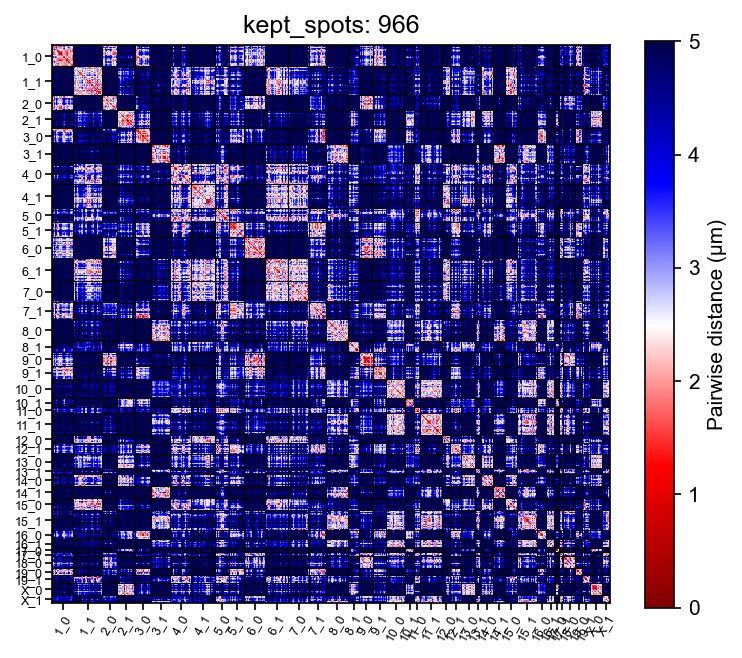

In [132]:
# test run one cell
%matplotlib inline
reload(decode)
decoder = decode.batch_decode_DNA(*decode_args[120])

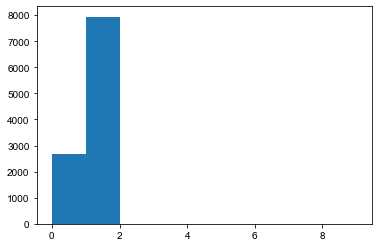

In [133]:
plt.figure()
plt.hist(decoder.spot_usage, bins=np.arange(10))
plt.show()
#plt.hist(decoder.spot_usage)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


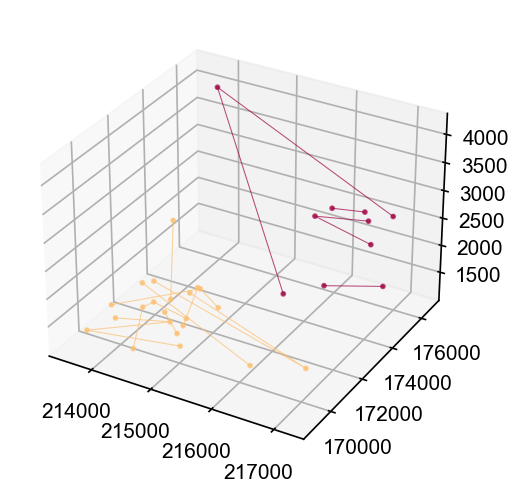

In [131]:
%matplotlib inline

def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['1']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
fig.show()

In [139]:
%%time
# old version
import multiprocessing as mp

print(len(decode_args))

with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

1673


ValueError: operands could not be broadcast together with shapes (5,) (0,) 

## load decode results

In [140]:
#decoder_folder = os.path.join(save_folder, 'Decoder')
decoder_filenames = [os.path.join(decoder_folder, _fl) for _fl in os.listdir(decoder_folder) 
                if _fl.split(os.path.extsep)[-1]=='pkl']
print(decoder_folder, len(decoder_filenames))

\\mendel\Mendel_SSD1\Pu_Temp\20220102-CTP11-1000_CTP12-DNA_from_1229\Decoder\v1 1214


### summarize final coordinates

In [141]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decoder_filenames]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

# summarize
decode_filenames = [_fl for _fl,_item in zip(decoder_filenames, all_chr_2_zxys_list) if _item is not None]
all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

1214
1214
Wall time: 52.6 s


In [142]:
%%time
import multiprocessing as mp
summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

print(len(summary_args))

with mp.Pool(44) as summary_pool: 
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

1214
Wall time: 1min 15s


## save

In [143]:
# save decode results
decode_save_dict = {
    'zxys':[],
    'fov_id':[],
    'cell_id':[],
}
for _zxys_list, _decoder_filename in zip(all_zxys_list, decoder_filenames):
    _fov_id = int(os.path.basename(_decoder_filename).split('zscan_')[1].split('_')[0])
    _cell_id = int(os.path.basename(_decoder_filename).split('Cell-')[1].split('_')[0])
    # append
    for _zxys in _zxys_list:
        decode_save_dict['zxys'].append(_zxys)
        decode_save_dict['fov_id'].append(_fov_id)
        decode_save_dict['cell_id'].append(_cell_id)

# save
decode_save_filename = os.path.join(decoder_folder, f"decode_zxys_fov_{min(decode_save_dict['fov_id'])}-{max(decode_save_dict['fov_id'])}.pkl")
print(f"Save decode_save_dict to file: {decode_save_filename}")
pickle.dump(decode_save_dict, open(decode_save_filename, 'wb'))

Save decode_save_dict to file: \\mendel\Mendel_SSD1\Pu_Temp\20220102-CTP11-1000_CTP12-DNA_from_1229\Decoder\v1\decode_zxys_fov_1-14.pkl


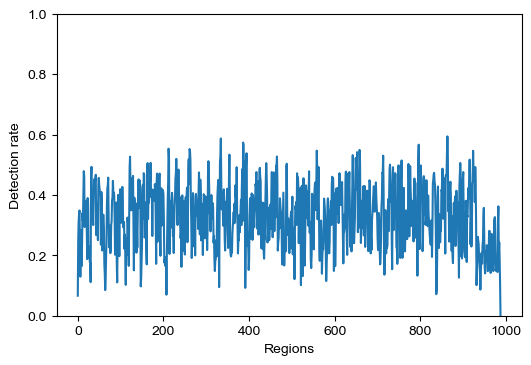

In [144]:
%matplotlib inline
all_zxys = np.array(decode_save_dict['zxys'])
loss_rates = np.mean(np.isnan(all_zxys).any(2), axis=0)
plt.figure(dpi=100)
plt.plot(1-loss_rates)
plt.ylim([0,1])
plt.xlabel('Regions')
plt.ylabel('Detection rate')
plt.show()

## Median distance map

In [145]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

#all_zxys_list = np.concatenate(all_zxys_list)
all_zxys_list = np.array(decode_save_dict['zxys'])

all_distmaps = [squareform(pdist(_zxys)) for _zxys in tqdm(all_zxys_list)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)

100%|███████████████████████████████████████████████████████████████████████████| 2428/2428 [00:31<00:00, 77.71it/s]


Wall time: 1min 56s


In [146]:
%%time
all_contactmaps = np.array(all_distmaps) <= 0.5

contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)

Wall time: 1min 16s


In [147]:
save_figure = True
#figure_folder = os.path.join(save_folder, 'Figures_final')
figure_folder = os.path.join(decoder_folder, 'Figures_final')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")

Create figure_folder: \\mendel\Mendel_SSD1\Pu_Temp\20220102-CTP11-1000_CTP12-DNA_from_1229\Decoder\v1\Figures_final


E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  
E:\Users\puzheng\Documents\ImageAnalysis3\figure_tools\distmap.py:39: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  vmin=min(color_limits), vmax=max(color_limits), **imshow_kwargs)
E:\Users\puzheng\AppData\anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


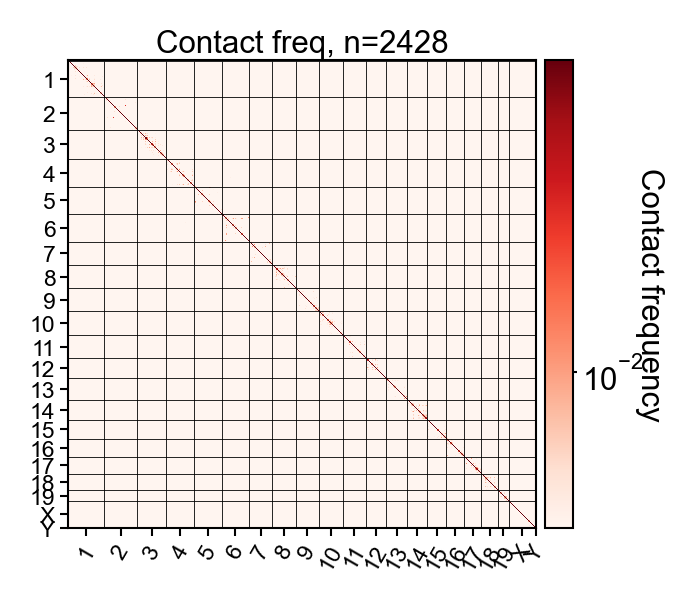

In [148]:
from matplotlib.colors import LogNorm
from matplotlib import cm

contact_limits = [0.005, 0.04]
contact_norm = LogNorm(vmin=np.min(contact_limits), 
                       vmax=np.max(contact_limits))
contact_cmap = cm.get_cmap('Reds')
contact_cmap.set_bad(color=[0.,0.,0.,1])

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(
    contactmap, 
    cmap=contact_cmap,
    color_limits=contact_limits,
    color_norm=contact_norm,
    colorbar_labels='Contact frequency',
    ax=ax,
)

ax.set_title(f'Contact freq, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_contact_map.png'), transparent=True)
fig.show()


<IPython.core.display.Javascript object>


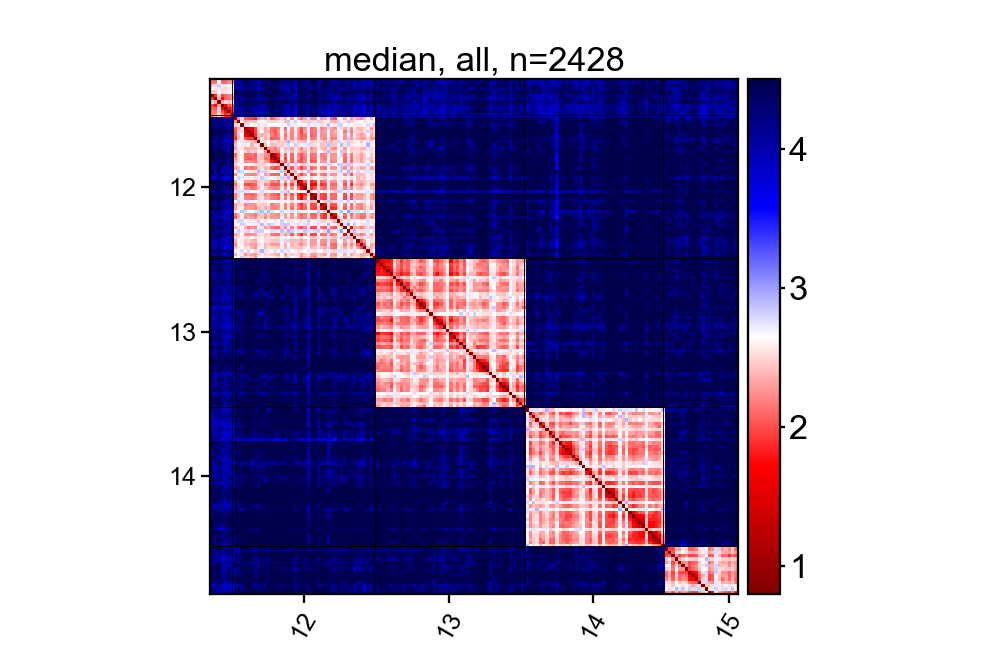

In [159]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.8,4.5],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)
if save_figure:
    fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()